In [57]:
import random
import numpy as np
import pygame
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import sys

In [58]:
# Hyperparameters
WIDTH, HEIGHT = 600, 400
CELL_SIZE = 20
FPS = 60

WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREEN = (0, 255, 0)
RED = (255, 0, 0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directions
UP = (0, -CELL_SIZE)
DOWN = (0, CELL_SIZE)
LEFT = (-CELL_SIZE, 0)
RIGHT = (CELL_SIZE, 0)

pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Snake DQN")
clock = pygame.time.Clock()
font = pygame.font.SysFont('Arial', 25)

In [59]:
# Drawing Helpers
def draw_snake(snake):
    for block in snake:
        pygame.draw.rect(screen, GREEN, pygame.Rect(block[0], block[1], CELL_SIZE, CELL_SIZE))

def draw_food(food):
    pygame.draw.rect(screen, RED, pygame.Rect(food[0], food[1], CELL_SIZE, CELL_SIZE))

def draw_text(text, pos):
    surface = font.render(text, True, WHITE)
    screen.blit(surface, pos)

In [60]:
#Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

In [61]:
#Neural Network for Q-function
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [62]:
# Snake Game Environment Class
class SnakeGame:
    def __init__(self):
        self.reset()

    def reset(self):
        self.snake = [(100, 100)]
        self.direction = RIGHT
        self.spawn_food()
        self.score = 0

    def spawn_food(self):
        while True:
            x = random.randint(0, WIDTH // CELL_SIZE - 1) * CELL_SIZE
            y = random.randint(0, HEIGHT // CELL_SIZE - 1) * CELL_SIZE
            if (x, y) not in self.snake:
                self.food = (x, y)
                break

    def get_state(self):
        head = self.snake[0]
        dir_l = (-self.direction[1], self.direction[0])
        dir_r = (self.direction[1], -self.direction[0])

        def danger_in_dir(dir):
            next_pos = (head[0] + dir[0], head[1] + dir[1])
            return (
                next_pos in self.snake or
                next_pos[0] < 0 or next_pos[0] >= WIDTH or
                next_pos[1] < 0 or next_pos[1] >= HEIGHT
            )

        danger_straight = danger_in_dir(self.direction)
        danger_right = danger_in_dir(dir_r)
        danger_left = danger_in_dir(dir_l)

        food_left = self.food[0] < head[0]
        food_right = self.food[0] > head[0]
        food_up = self.food[1] < head[1]
        food_down = self.food[1] > head[1]

        dir_up = self.direction == UP
        dir_down = self.direction == DOWN
        dir_left = self.direction == LEFT
        dir_right = self.direction == RIGHT

        return np.array([
            danger_straight, danger_right, danger_left,
            food_up, food_down, food_left, food_right,
            dir_up, dir_down, dir_left, dir_right
        ], dtype=int)

    def play_step(self, action):
        if action == 1:
            self.direction = (self.direction[1], -self.direction[0])
        elif action == 2:
            self.direction = (-self.direction[1], self.direction[0])

        head = self.snake[0]
        new_head = (head[0] + self.direction[0], head[1] + self.direction[1])
        self.snake.insert(0, new_head)

        if (
            new_head in self.snake[1:] or
            new_head[0] < 0 or new_head[0] >= WIDTH or
            new_head[1] < 0 or new_head[1] >= HEIGHT
        ):
            return -10, True, self.score

        reward = -0.1
        if new_head == self.food:
            self.score += 1
            reward = 10
            self.spawn_food()
        else:
            self.snake.pop()

        return reward, False, self.score

    def render(self):
        screen.fill(BLACK)
        draw_snake(self.snake)
        draw_food(self.food)
        draw_text(f"Score: {self.score}", (10, 10))
        pygame.display.flip()
        clock.tick(FPS)

In [63]:
#DQN Agent Class
class DQNAgent:
    def __init__(self, input_dim, output_dim):
        self.model = DQN(input_dim, output_dim).to(device)
        self.target_model = DQN(input_dim, output_dim).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criteria = nn.MSELoss()
        self.epsilon = 1.0
        self.min_epsilon = 0.01
        self.epsilon_decay = 0.995
        self.gamma = 0.9

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 2)
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def train(self, replay_buffer, batch_size):
        if len(replay_buffer) < batch_size:
            return

        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state = torch.FloatTensor(state).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        action = torch.LongTensor(action).unsqueeze(1).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        q_values = self.model(state).gather(1, action)
        with torch.no_grad():
            max_next_q_values = self.target_model(next_state).max(1)[0].unsqueeze(1)
            target_q_values = reward + self.gamma * max_next_q_values * (1 - done)

        loss = self.criteria(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

In [64]:
#Training Loop
EPISODES = 500
BATCH_SIZE = 64
TARGET_UPDATE = 10
RENDER = True  # <--- SET THIS TO TRUE TO SEE THE GAME
RENDER_EVERY = 10  # Render every N episodes for performance

env = SnakeGame()
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(input_dim=11, output_dim=3)

scores = []

for episode in range(EPISODES):
    env.reset()
    state = env.get_state()
    total_reward = 0

    while True:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

        action = agent.select_action(state)
        reward, done, score = env.play_step(action)
        next_state = env.get_state()
        replay_buffer.push(state, action, reward, next_state, done)

        agent.train(replay_buffer, BATCH_SIZE)

        state = next_state
        total_reward += reward

        if RENDER:
            env.render()

        if done:
            scores.append(score)
            print(f"Episode {episode+1}: Score = {score}, Epsilon = {agent.epsilon:.3f}")
            break

    agent.decay_epsilon()
    if episode % TARGET_UPDATE == 0:
        agent.update_target()

Episode 1: Score = 0, Epsilon = 1.000
Episode 2: Score = 0, Epsilon = 0.995
Episode 3: Score = 0, Epsilon = 0.990
Episode 4: Score = 0, Epsilon = 0.985
Episode 5: Score = 0, Epsilon = 0.980
Episode 6: Score = 0, Epsilon = 0.975
Episode 7: Score = 0, Epsilon = 0.970
Episode 8: Score = 0, Epsilon = 0.966
Episode 9: Score = 0, Epsilon = 0.961
Episode 10: Score = 0, Epsilon = 0.956
Episode 11: Score = 0, Epsilon = 0.951
Episode 12: Score = 0, Epsilon = 0.946
Episode 13: Score = 0, Epsilon = 0.942
Episode 14: Score = 0, Epsilon = 0.937
Episode 15: Score = 0, Epsilon = 0.932
Episode 16: Score = 0, Epsilon = 0.928
Episode 17: Score = 0, Epsilon = 0.923
Episode 18: Score = 0, Epsilon = 0.918
Episode 19: Score = 0, Epsilon = 0.914
Episode 20: Score = 1, Epsilon = 0.909
Episode 21: Score = 0, Epsilon = 0.905
Episode 22: Score = 0, Epsilon = 0.900
Episode 23: Score = 0, Epsilon = 0.896
Episode 24: Score = 0, Epsilon = 0.891
Episode 25: Score = 0, Epsilon = 0.887
Episode 26: Score = 0, Epsilon = 0

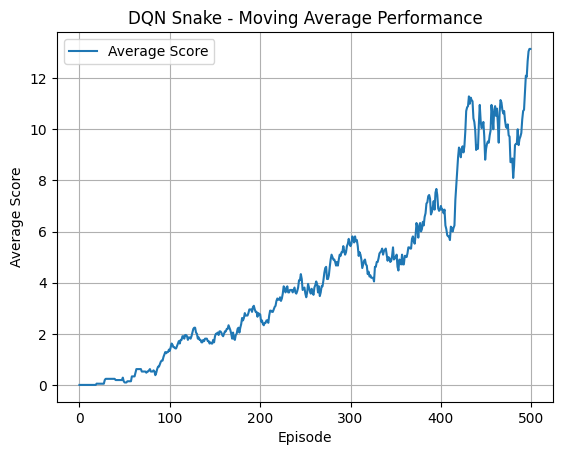

In [65]:
window_size = 20
avg_scores = [np.mean(scores[max(0, i - window_size):(i + 1)]) for i in range(len(scores))]

plt.plot(scores, label="Average Score")
plt.xlabel("Episode")
plt.ylabel("Average Score")
plt.title("DQN Snake - Moving Average Performance")
plt.grid(True)
plt.legend()
plt.show()